In [16]:
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings

from scipy import stats
from shapely.geometry import Polygon
from ipyleaflet import (
     Map,
     basemaps,
     DrawControl,
     GeoData,
)

In [17]:
#load cali grid in map
center = [38,-120]
zoom = 7

m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)
df = gpd.read_file('sets/cali1.geojson').drop(columns=['Creator_Date', 'Last_Editor_Date'])
grid = GeoData(geo_dataframe = df, style={})
m.add(grid)

#add draw polygon func
draw_control = DrawControl(edit=False, circlemarker={}, polyline={}, 
                           polygon = {
                            "shapeOptions": {
                                "fillColor": "#FF0000",
                                "color": "#FF0000",
                                "fillOpacity": 0.5
                            }})
m.add(draw_control)
m

Map(center=[38, -120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [3]:
#ignore future version err
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #map based filter
    b = draw_control.last_draw['geometry']['coordinates'][0]
    poly = Polygon(b[:-1])
    clipped = df.clip(poly)
    coords = clipped.get_coordinates().to_numpy().tolist()

In [4]:
#fill up line features with points (increase complexity)
def fill_between_points(pointa, pointb,n):
    (xmin,ymin) = pointa;
    (xmax,ymax) = pointb;
    return [[xmin + i*(xmax-xmin)/n,ymin + i*(ymax-ymin)/n] for i in range(n)] + [[xmax,ymax]]

new = []
for i in range(len(coords)-1):
    new.extend(fill_between_points(coords[i], coords[i+1], 500))
len(new)

3613713

In [5]:
def generate_bin_edges(bounds,l):
    
    (xrange,yrange) = bounds
    (xmin,xmax) = xrange
    (ymin,ymax) = yrange
    
    nx = (xmax-xmin)/l;
    ny = (ymax-ymin)/l;
    
    xlocs = np.linspace(xmin,xmax-l,math.ceil(nx));
    ylocs = np.linspace(ymin,ymax-l,math.ceil(ny));
            
    return (xlocs,ylocs)

def get_count(allcoords,l):
    longs = [x[0] for x in allcoords]
    lats  = [x[1] for x in allcoords]
    
    boundlong = (min(longs), max(longs))
    boundlat = (min(lats), max(lats))
    
    grid, _, _ = np.histogram2d(longs, lats,bins=generate_bin_edges((boundlong,boundlat),l))
    return np.count_nonzero(grid)

def get_dimension(scale,counts):
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(scale),np.log(counts))

    dimension = -slope
    return dimension

In [10]:
ls = np.logspace(-2,-5,10)
counts = [0]*len(ls)

print('Intervals   ','Boxes')
s1= "          "
s2= "         "
for i in range(len(ls)):
    counts[i] = get_count(new,ls[i])
    if ((i+1)>=10):
        print(i+1,s2,counts[i])
    if ((i+1)<10):
        print(i+1,s1,counts[i]) 

Intervals    Boxes
1            652
2            2333
3            7233
4            19503
5            47134
6            104104
7            196290
8            342055
9            599289
10           1093606


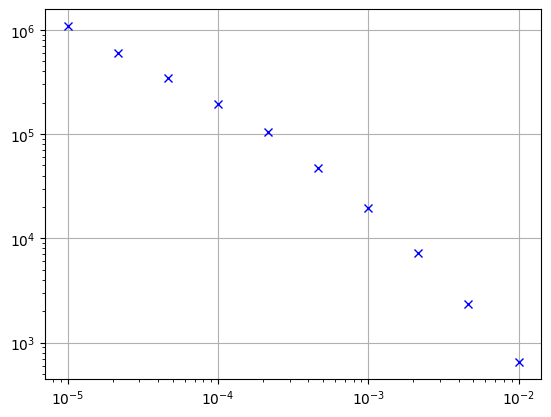

Fractal Dimension: 1.0475632971184716


In [11]:
plt.loglog(ls,counts,'bx')
plt.grid("True")
plt.show()
print('Fractal Dimension:',get_dimension(ls,counts))